## This is the benchmark model for the LSTM Stock Prediction Model

In [39]:
import math
import matplotlib
import numpy as np
import pandas as pd

import pandas_datareader as web
from datetime import date
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [40]:
df = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2020-03-31')

In [41]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970


In [42]:
df = df.reset_index()

In [43]:
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [44]:
df['month'] = df['date'].dt.month
df.sort_values(by='date', inplace=True, ascending=True)

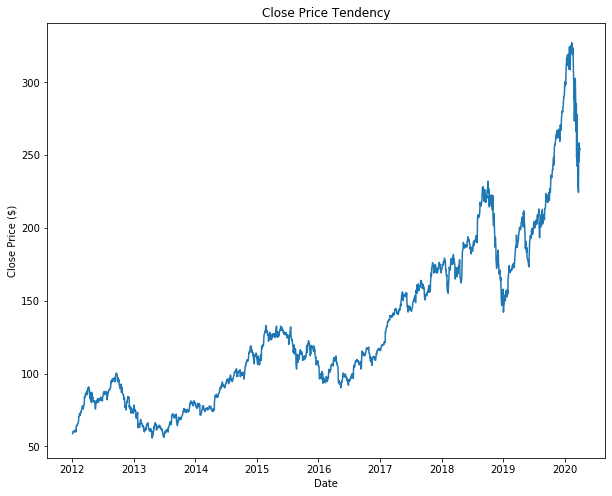

In [45]:
#visualize the data
plt.figure(figsize=(10,8))
plt.title("Close Price Tendency")
plt.plot(df['date'],df['close'])
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [46]:
num_cv = int(.2*len(df))
num_test = int(.2*len(df))
num_train = len(df) - num_cv - num_test

# Split into train, cross-val, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (1246, 8)
cv.shape = (414, 8)
train_cv.shape = (1660, 8)
test.shape = (414, 8)


### The below function trains and predicts the model

In [47]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['close'])):
        X_train = np.array(range(len(df['close'][i-N:i])))
        y_train = np.array(df['close'][i-N:i])
        X_train = X_train.reshape(-1, 1)   
        y_train = y_train.reshape(-1, 1)
        regr.fit(X_train, y_train) 
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])
    
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

In [48]:
for N in range(1, 61): 
    predictions_list = get_preds_lin_reg(train_cv, 'close', N, 0, num_train)
    cv.loc[:, 'pred' + '_N' + str(N)] = predictions_list


In [49]:
len(predictions_list)

414

In [50]:
rmse=np.sqrt(np.mean(((predictions_list- test['close'])**2)))
print("RMSE = %0.3f" % rmse)

RMSE = 70.672


Text(0, 0.5, 'USD')

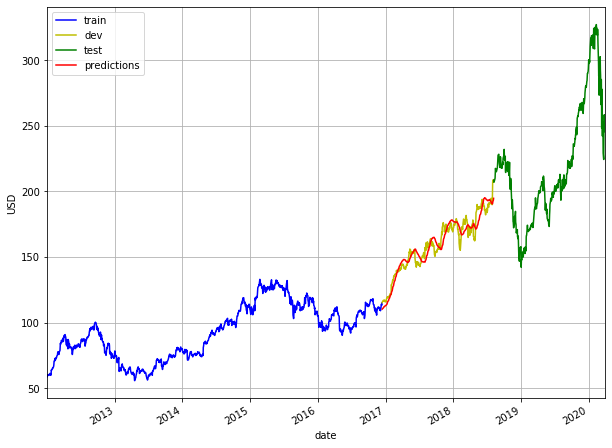

In [51]:
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='pred_N60', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")